# Anomaly Detection - Credit Card Fraud Analysis

https://nanunzoey.tistory.com/entry/%EC%9D%B4%EC%83%81-%ED%83%90%EC%A7%80Anomaly-Detection-%EA%B8%B0%EB%B2%95%EC%9D%98-%EC%A2%85%EB%A5%98\
분류 기반(오토인코더, 베이지안 네트워크, SVM, 결정트리)\
Nearest Neighbor 기반(KNN, 상대 밀도)\
클러스터링 기반(DBSCAN, SNN 군집화 최적화는 X/ 자기조직화지도(SOM), K-Means ... \
통계적 기법\
스펙트럴 기법(PCA)

Neural Network\
Isolation Forest\
OneClassSVM\
Local Outlier Factor\
DBSCAN

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime 

In [4]:
train = pd.read_csv('train.csv', index_col='ID')
val = pd.read_csv('val.csv', index_col='ID')
test = pd.read_csv('test.csv', index_col='ID')

In [4]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "NanumGothic"
plt.style.use('ggplot')
import seaborn as sns

In [5]:
train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')

In [6]:
train.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
ID,,,,,,,,,,,,,,,,,,,,,
3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972


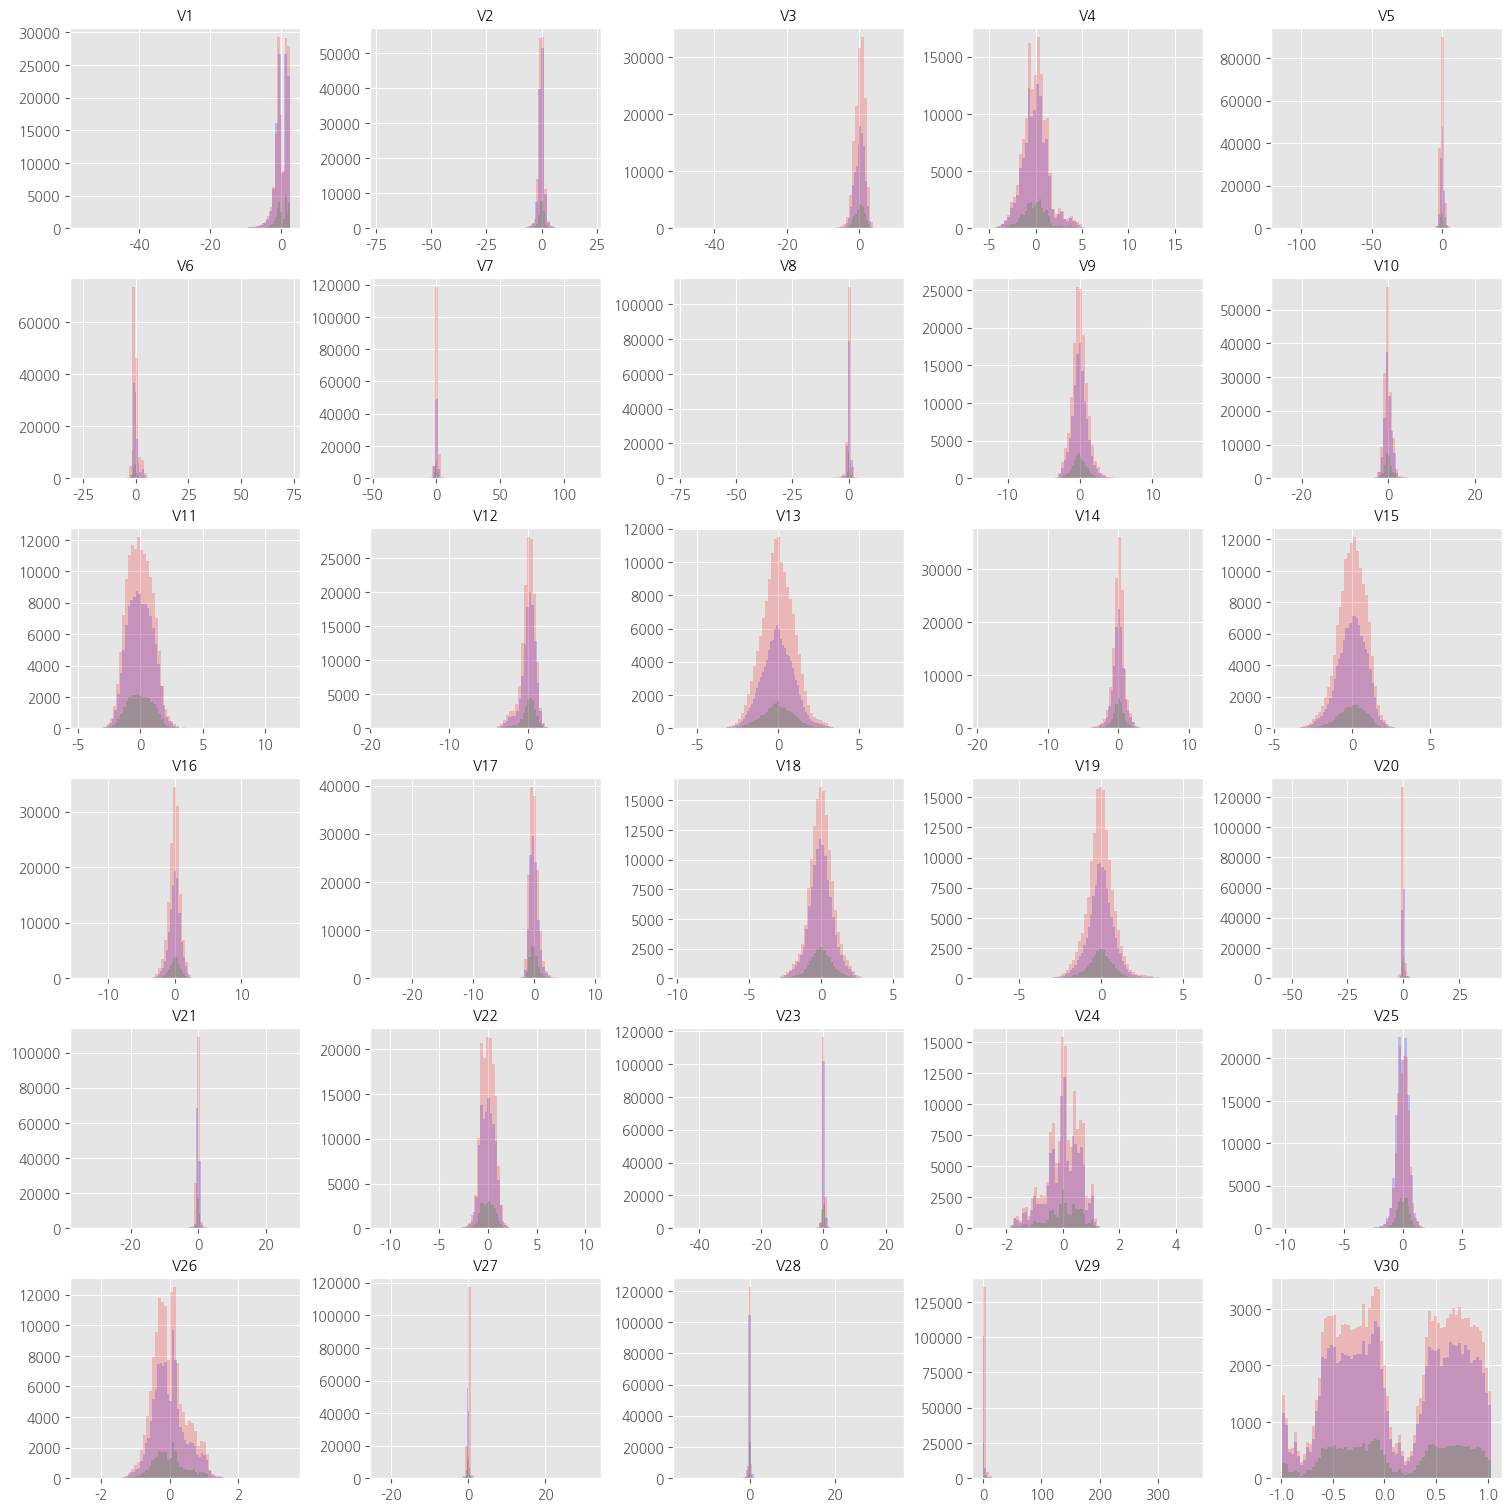

In [7]:
# 데이터셋별 분포 확인
fig, axes = plt.subplots(6,5, figsize = (15, 15), constrained_layout=True)
font_dict={'fontsize': 10}
row=0
col=0
for c in train.columns:
    axes[row,col].hist(train[c],color="blue", bins=70, alpha=0.2, label="train")
    axes[row,col].hist(test[c],color="red", bins=70, alpha=0.2, label="test")
    axes[row,col].hist(val[c],color="green", bins=70, alpha=0.2, label="val")
    axes[row,col].set_title(c, fontdict=font_dict)
    col+=1
    if col==5:
        row+=1
        col=0
plt.show()

<AxesSubplot: >

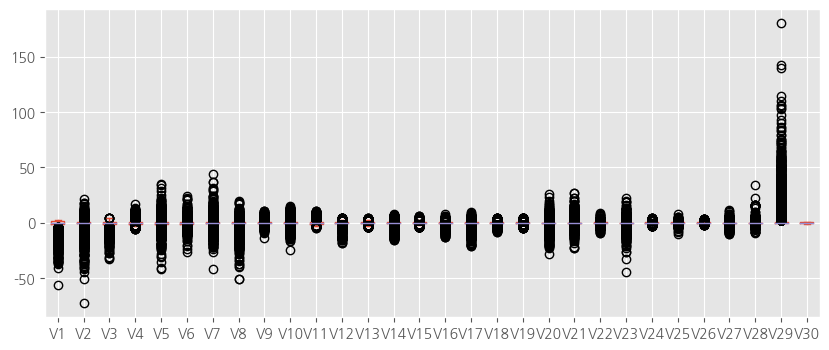

In [8]:
train.plot(kind='box', figsize=(10,4))

## Validation set

In [12]:
val_normal, val_fraud = val['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(val['Class'].value_counts())
print(f'Validation contamination : [{val_contamination}]')

0    28432
1       30
Name: Class, dtype: int64
Validation contamination : [0.0010551491277433877]


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(val.iloc[:,:-1])
val_scaled = scaler.transform(val.iloc[:,:-1])
val_scaled = pd.DataFrame(val_scaled, columns= val.columns[:-1])

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(val_scaled.iloc[:,:-1])

df_pca = pca.transform(val_scaled.iloc[:,:-1])
df_pca = pd.DataFrame(df_pca, columns = ['component 0', 'component 1', 'component 2'])
print(pca.explained_variance_ratio_)#설명력 좋지 않음
df_pca

[0.06922985 0.03839493 0.03835898]


,component 0,component 1,component 2
0,-0.479864,-0.355810,0.766044
1,-0.352026,-0.662247,0.314777
2,-0.291501,-0.977313,-0.072797
3,-0.279779,0.232450,0.021478
4,0.097880,0.419821,2.235247
...,...,...,...
28457,-0.335560,-0.082873,1.105923
28458,-0.000940,0.575831,0.178867
28459,-0.193865,-0.966892,0.592492
28460,-0.480245,-0.950949,0.285325


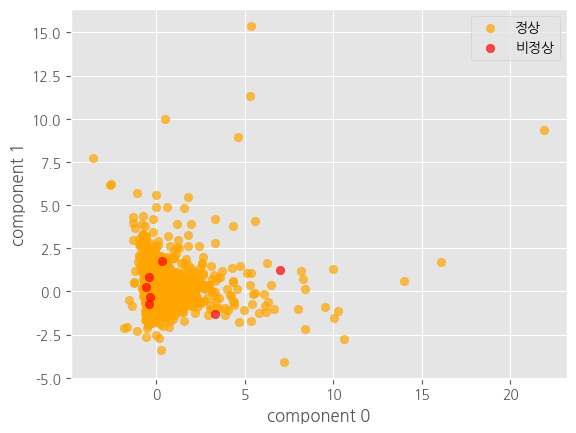

In [27]:
# class target 정보 불러오기 
df_pca['target'] = val['Class']

# target 별 분리
df_pca_0 = df_pca[df_pca['target'] == 0]
df_pca_1 = df_pca[df_pca['target'] == 1]

# target 별 시각화
plt.scatter(df_pca_0['component 0'], df_pca_0['component 1'], color = 'orange', alpha = 0.7, label = '정상')
plt.scatter(df_pca_1['component 0'], df_pca_1['component 1'], color = 'red', alpha = 0.7, label = '비정상')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

<AxesSubplot: >

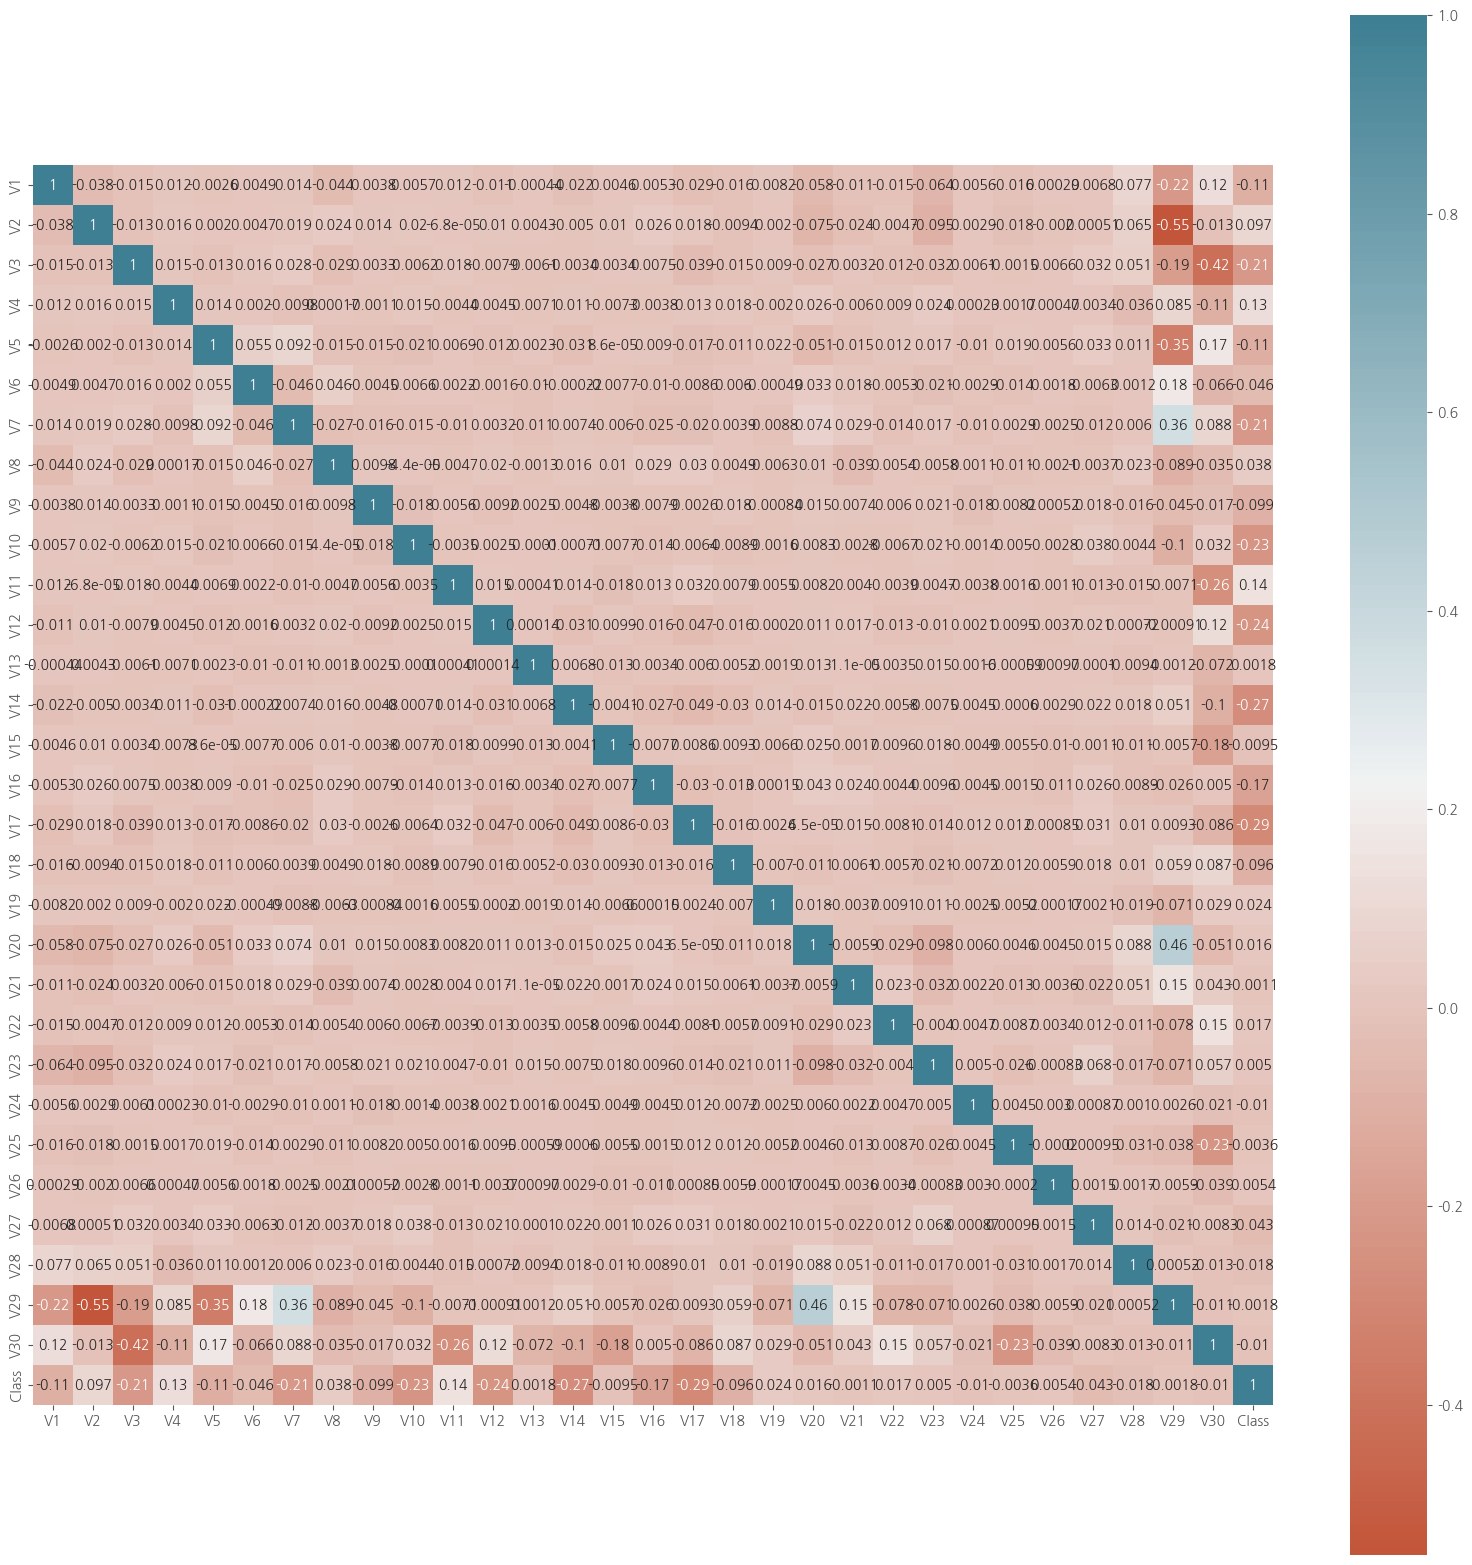

In [10]:
corrMatt = val.corr()
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(corrMatt, annot=True, cmap=sns.diverging_palette(20, 220, n=200), square=True)  #대부분이 서로 관련없고, V29, V30에 대해서 상관성이 있는편

C:\Users\junel\AppData\Local\Temp\ipykernel_23484\207672328.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val.loc[val['Class'] == 0, c], bins=20, color='skyblue', label='normal', ax=axs[row, col])
C:\Users\junel\AppData\Local\Temp\ipykernel_23484\207672328.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

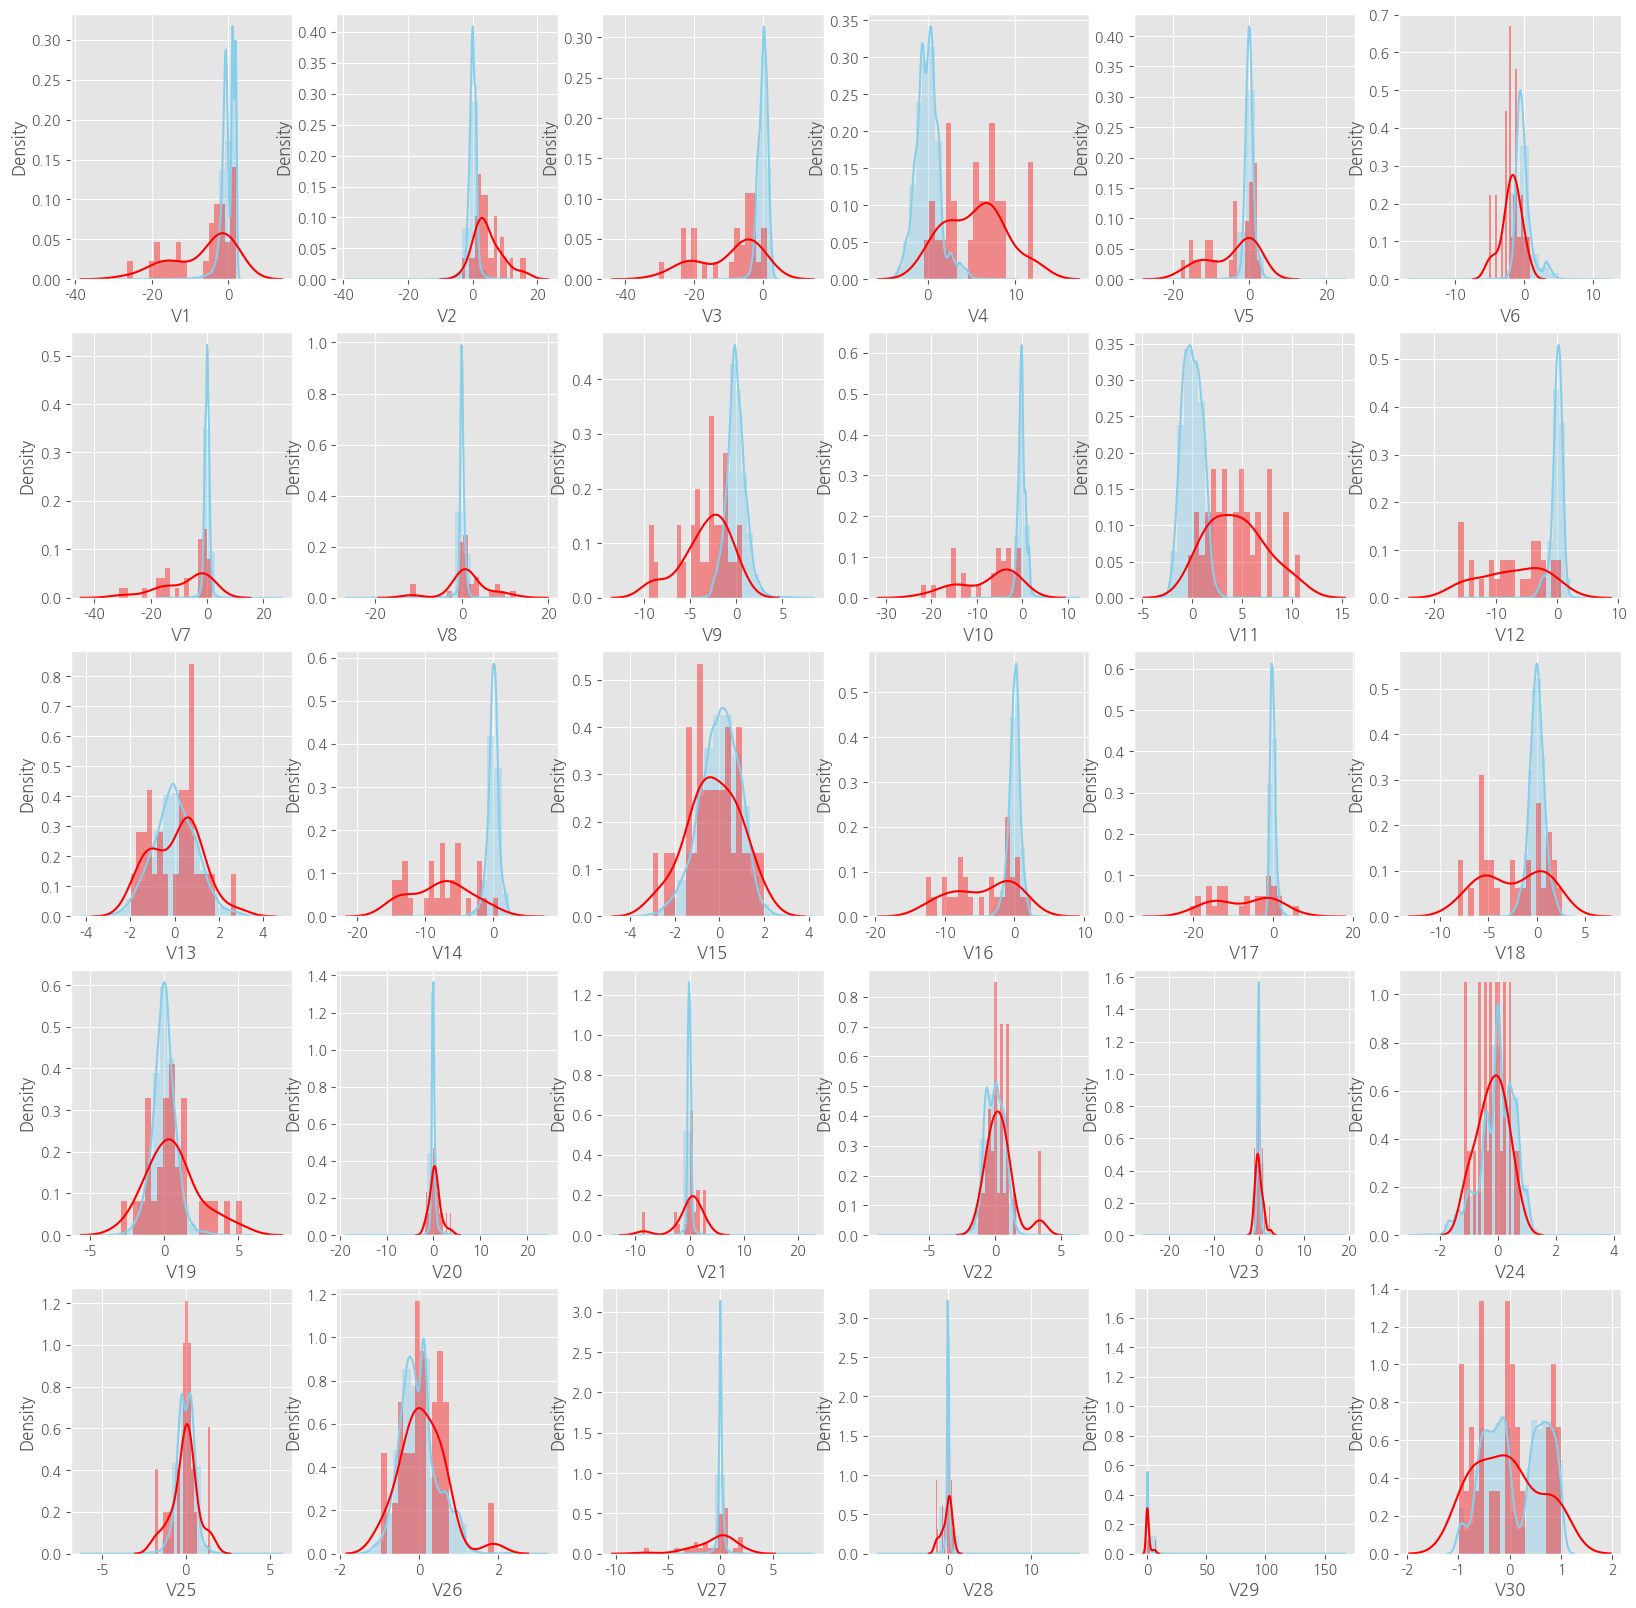

In [11]:
fig, axs = plt.subplots(5,6, figsize=(20,20))
row, col = 0, 0
for c in val.columns[:-1]:
  sns.distplot(val.loc[val['Class'] == 0, c], bins=20, color='skyblue', label='normal', ax=axs[row, col])
  sns.distplot(val.loc[val['Class'] == 1, c], bins=20, color='red', label='outlier', ax=axs[row, col])
  col+=1
  if col==6:
    col=0
    row+=1
plt.show() 
#확실히 몇 변수에서 분포가 다른 모습 확인 가능 (V1, V3, V4, V5, V7, V8, V9, V10, V11, V12, V14, V16, V17, V18)

분산이 서로 다른 변수를 ANOVA로 검출

In [31]:
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [54]:
anova_sel = []
anova_results={}
for c in val.columns[:-1]:
    group0 = val.loc[val['Class'] == 0, c]
    group1 = val.loc[val['Class'] == 1, c]
    F_statistic, pVal = stats.f_oneway(group0, group1)
    
    if pVal < 0.005:
        print('**** {} 일원분산분석 결과 : F={}, p={}'.format(c, F_statistic, pVal))
        print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')
        anova_sel.append(c)
        anova_results[c]=[F_statistic, pVal]
print(anova_sel)

**** V1 일원분산분석 결과 : F=344.0045063301024, p=2.416759747650182e-76
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V2 일원분산분석 결과 : F=269.3271389211836, p=3.010169129972998e-60
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V3 일원분산분석 결과 : F=1343.8685559359858, p=1.6231646754344736e-287
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V4 일원분산분석 결과 : F=460.20040276648103, p=2.7612275557485516e-101
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V5 일원분산분석 결과 : F=363.20192426620906, p=1.7953276560228514e-80
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V6 일원분산분석 결과 : F=59.49941733964649, p=1.2631971768385718e-14
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V7 일원분산분석 결과 : F=1376.7640454177829, p=2.443674922779757e-294
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V8 일원분산분석 결과 : F=41.937587189227294, p=9.576917434342331e-11
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
**** V9 일원분산분석 결과 : F=279.78379249909176, p=1.66540569031220

In [7]:
#anova_sel=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V22', 'V27', 'V28']

In [58]:
anova_results

{'V1': [344.0045063301024, 2.416759747650182e-76],
 'V2': [269.3271389211836, 3.010169129972998e-60],
 'V3': [1343.8685559359858, 1.6231646754344736e-287],
 'V4': [460.20040276648103, 2.7612275557485516e-101],
 'V5': [363.20192426620906, 1.7953276560228514e-80],
 'V6': [59.49941733964649, 1.2631971768385718e-14],
 'V7': [1376.7640454177829, 2.443674922779757e-294],
 'V8': [41.937587189227294, 9.576917434342331e-11],
 'V9': [279.78379249909176, 1.6654056903122046e-62],
 'V10': [1543.5025559133737, 0.0],
 'V11': [586.3643322305546, 3.0766200118701704e-128],
 'V12': [1728.1932685733025, 0.0],
 'V14': [2253.1336863277434, 0.0],
 'V16': [842.2747048888943, 1.590710036323031e-182],
 'V17': [2621.817312585418, 0.0],
 'V18': [265.30800650478784, 2.2203618381344917e-59],
 'V19': [16.709297275011345, 4.3686468751657595e-05],
 'V22': [8.223049373075867, 0.004139201372059857],
 'V27': [53.03281846512265, 3.3652685635794034e-13],
 'V28': [9.385141397120229, 0.002189555573379647]}

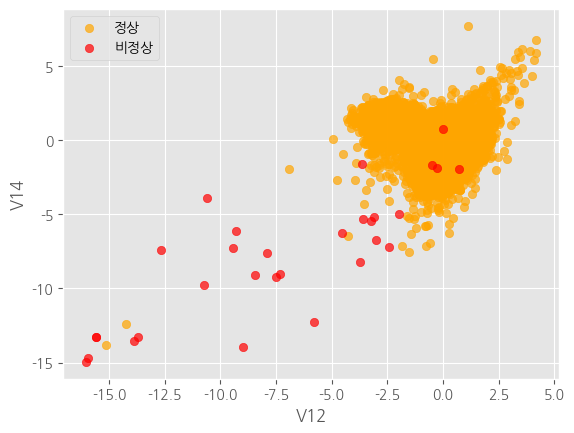

In [60]:
# target 별 분리
scatter_0 = val[val['Class'] == 0]
scatter_1 = val[val['Class'] == 1]

# target 별 시각화
plt.scatter(scatter_0['V12'], scatter_0['V14'], color = 'orange', alpha = 0.7, label = '정상')
plt.scatter(scatter_1['V12'], scatter_1['V14'], color = 'red', alpha = 0.7, label = '비정상')

plt.xlabel('V12')
plt.ylabel('V14')
plt.legend()
plt.show()

## Modeling

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [9]:
def ae_confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

In [10]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred 

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(val.iloc[:,:-1])
val_scaled = scaler.transform(val.iloc[:,:-1])
val_scaled = pd.DataFrame(val_scaled, columns= val.columns[:-1])

In [8]:
selected = train[anova_sel]
selected_train_scaled = scaler.fit_transform(selected)
selected_train_scaled = pd.DataFrame(selected_train_scaled, columns= anova_sel)
selected_train_scaled.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V16,V17,V18,V19,V22,V27,V28
0,-0.696317,-0.812481,1.178089,0.271798,-0.368309,1.349308,0.652511,0.210988,-1.380804,0.188955,0.617126,0.06360,-0.182429,-3.344884,1.368591,-0.147424,-2.777225,1.066111,-0.137969,-0.166355
1,-0.495358,-0.112967,1.191305,-0.608173,-0.007886,0.933476,0.192541,0.320444,-1.264291,-0.056156,-0.221548,0.17838,-0.313062,-1.228527,-0.850277,2.364897,-1.513644,0.007285,0.157587,0.173998


In [9]:
val_x = val.drop(columns=['Class']) # Input Data
val_y = val['Class'] # Label
selected_val_x = val_x[anova_sel]
selected_val_scaled = scaler.transform(selected_val_x)
selected_val_scaled = pd.DataFrame(selected_val_scaled, columns= anova_sel)
selected_val_scaled.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V16,V17,V18,V19,V22,V27,V28
0,-0.173475,0.677327,0.691190,-0.154335,0.364809,-0.189318,0.536344,0.060725,-0.670635,-0.347282,1.00455,0.852012,-0.479701,0.851599,-0.673277,0.572443,0.554268,-0.875560,0.616898,0.234701
1,0.493220,0.198159,-0.121047,1.496059,0.825644,1.270800,0.084662,0.441968,-1.085624,0.671301,1.66753,0.412298,1.048828,-0.699662,0.493585,-2.092394,-2.489645,0.556061,0.041562,-0.039585


### grid search hyperparameter tuning

In [116]:
from sklearn.model_selection import GridSearchCV, train_test_split
# parameter setting
n_estimators = list(range(300, 1000, 200))
max_features = [1, 2, 5, 10, 20]

result = pd.DataFrame(columns=['n_estimators', 'max_features', 'f1'])
# fitting and check
for n_est in n_estimators:
  for mf in max_features:
    model = IsolationForest(n_estimators=n_est, max_samples=len(selected), max_features=mf, contamination=val_contamination, random_state=1, verbose=0)
    model.fit(selected_train_scaled.values)

    y_pred_valid = get_pred_label(model.predict(selected_val_scaled.values)) # model prediction and label conversion
    f1 = f1_score(val_y, y_pred_valid, average='macro')
    result.loc[len(result)] = [n_est, mf, f1]

    print(f'n_estimator : {n_est}, max_features : {mf} ====> f1 : {f1}')

n_estimator : 400, max_features : 1 ====> f1 : 0.7128069968572724
n_estimator : 400, max_features : 2 ====> f1 : 0.7128069968572724
n_estimator : 400, max_features : 5 ====> f1 : 0.7370155601953483
n_estimator : 400, max_features : 10 ====> f1 : 0.7102361650869573
n_estimator : 400, max_features : 20 ====> f1 : 0.7370155601953483
n_estimator : 600, max_features : 1 ====> f1 : 0.7128069968572724
n_estimator : 600, max_features : 2 ====> f1 : 0.7163677077471393
n_estimator : 600, max_features : 5 ====> f1 : 0.7370155601953483
n_estimator : 600, max_features : 10 ====> f1 : 0.7370155601953483
n_estimator : 600, max_features : 20 ====> f1 : 0.7370155601953483
n_estimator : 800, max_features : 1 ====> f1 : 0.7128069968572724
n_estimator : 800, max_features : 2 ====> f1 : 0.7163677077471393
n_estimator : 800, max_features : 5 ====> f1 : 0.7370155601953483
n_estimator : 800, max_features : 10 ====> f1 : 0.7370155601953483
n_estimator : 800, max_features : 20 ====> f1 : 0.7370155601953483
n_es

unscaled: IsolationForest(n_estimator=500, max_features=5) ====> f1 : 0.7411155323403962\
n_estimator : 400, max_features : 5 ====> f1 : 0.7370155601953483

In [119]:
# parameter setting
n_neighbors = list(range(100, 1000, 100))

result = pd.DataFrame(columns=['n_neighbors', 'f1'])
# fitting and check
for n_nei in n_neighbors:
  model = LocalOutlierFactor(n_neighbors=n_nei, contamination = val_contamination, novelty=True, n_jobs=-1)
  model.fit(selected_train_scaled.values)

  y_pred_valid = get_pred_label(model.predict(selected_val_scaled.values)) # model prediction and label conversion
  f1 = f1_score(val_y, y_pred_valid, average='macro')
  result.loc[len(result)] = [n_nei, f1]

  print(f'n_neighbors : {n_nei} ====> f1 : {f1}')

n_neighbors : 100 ====> f1 : 0.571006541464444
n_neighbors : 200 ====> f1 : 0.7706399301404224
n_neighbors : 300 ====> f1 : 0.8198417554594366
n_neighbors : 400 ====> f1 : 0.8198417554594366
n_neighbors : 500 ====> f1 : 0.8059554160125588
n_neighbors : 600 ====> f1 : 0.8059554160125588
n_neighbors : 700 ====> f1 : 0.7939330251820103
n_neighbors : 800 ====> f1 : 0.7798065900059782
n_neighbors : 900 ====> f1 : 0.7798065900059782


unsclaed: LocalOutlierFactor(n_neighbors=300) ====> f1 : 0.857002180488148\
n_neighbors : 500 ====> f1 : 0.8059554160125588



In [120]:
# parameter setting
kernels = ['rbf', 'sigmoid']
gammas = ['scale', 'auto']

result = pd.DataFrame(columns=['kernel', 'gamma', 'f1'])
# fitting and check
for k in kernels:
  for g in gammas:
    model = OneClassSVM(kernel=k, nu=val_contamination, gamma = g)
    model.fit(selected_train_scaled.values)

    y_pred_valid = get_pred_label(model.predict(selected_val_scaled.values)) # model prediction and label conversion
    f1 = f1_score(val_y, y_pred_valid, average='macro')
    result.loc[len(result)] = [k, g, f1]

    print(f'kernel : {k}, gamma : {g} ====> f1 : {f1}')

kernel : rbf, gamma : scale ====> f1 : 0.5458932384459217
kernel : rbf, gamma : auto ====> f1 : 0.5458932384459217
kernel : sigmoid, gamma : scale ====> f1 : 0.535257086586481
kernel : sigmoid, gamma : auto ====> f1 : 0.535257086586481


unscaled: OneClassSVM(kernel=sigmoid, gamma=auto) ====> f1 : 0.5957845959076793\
kernel : rbf, gamma : auto ====> f1 : 0.5458932384459217

### PYOD

In [10]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA

In [20]:
classifiers = {
        'HBOS': HBOS(contamination=val_contamination),
        'PCA': PCA(n_components=20, contamination=val_contamination, svd_solver='auto', random_state=1),
        'AutoEncoder' : AutoEncoder(contamination=val_contamination, hidden_neurons=[32,8,8,32], preprocessing=False, verbose=0, random_state=1)
}

# model fitting
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(selected)
    y_pred = clf.predict(selected_val_x)#clf.labels_
    print(clf_name)
    print('f1 : ',round(f1_score(val_y,y_pred),3))
    print('-------------------')

HBOS
f1 :  0.483
-------------------
PCA
f1 :  0.379
-------------------
890/890 [==============================] - 1s 692us/step
AutoEncoder
f1 :  0.367
-------------------


## Submission

In [121]:
model = LocalOutlierFactor(n_neighbors=n_nei, contamination = val_contamination, novelty=True, n_jobs=-1)
model.fit(selected.values)

LocalOutlierFactor(contamination=0.0010551491277433877, n_jobs=-1,
                   n_neighbors=900, novelty=True)

In [ ]:
test_x=test[anova_sel]
test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

In [124]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = test_pred
submit.to_csv('./LocalOutlierFactor.csv', index=False)

public:	0.8200610656\
private: 0.7970931815	

In [ ]:
"""from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

X_samp, y_samp = SMOTETomek(random_state=4).fit_sample(X_imb, y_imb)
X_samp, y_samp = SMOTETomek(random_state=4).fit_sample(X_imb, y_imb)"""